In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Load the dataset
file_path = "D:/capstone/datasets/Affinity - State - Daily.xlsx"  # Adjust path if needed
df = pd.read_excel(file_path)
print(f"Dataset shape: {df.shape}")

# Preview the data
print("\nFirst few rows:")
display(df.head())

# Check columns
print("\nColumns in the dataset:")
print(df.columns.tolist())

# Basic information about the dataset
print("\nDataset information:")
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape: (50694, 29)

First few rows:


,year,month,day,statefips,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,...,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,provisional
0,2018,12,31,1,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
1,2018,12,31,2,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
2,2018,12,31,4,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
3,2018,12,31,5,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
4,2018,12,31,6,d,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0



Columns in the dataset:
['year', 'month', 'day', 'statefips', 'freq', 'spend_all', 'spend_aap', 'spend_acf', 'spend_aer', 'spend_apg', 'spend_durables', 'spend_nondurables', 'spend_grf', 'spend_gen', 'spend_hic', 'spend_hcs', 'spend_inperson', 'spend_inpersonmisc', 'spend_remoteservices', 'spend_sgh', 'spend_tws', 'spend_retail_w_grocery', 'spend_retail_no_grocery', 'spend_all_incmiddle', 'spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4', 'provisional']

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50694 entries, 0 to 50693
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   year                     50694 non-null  int64 
 1   month                    50694 non-null  int64 
 2   day                      50694 non-null  int64 
 3   statefips                50694 non-null  int64 
 4   freq                     50694 non-null  object
 5   spend_all            

In [2]:
# Create a proper date column
if 'date' not in df.columns:
    if all(col in df.columns for col in ['year', 'month', 'day']):
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        print("Created date column from year, month, and day columns")

# Identify spending columns
spend_cols = [col for col in df.columns if 'spend' in col.lower()]
print(f"Found {len(spend_cols)} spending-related columns")

# Clean spending columns
for col in spend_cols:
    # Convert to numeric, handling any non-numeric values
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col].replace('.', np.nan), errors='coerce')

# Handle missing values with interpolation
for col in spend_cols:
    missing_before = df[col].isna().sum()
    if missing_before > 0:
        df[col] = df[col].interpolate(method='linear')
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        missing_after = df[col].isna().sum()
        print(f"Column '{col}': {missing_before} missing values before, {missing_after} after cleaning")

# Focus on total spending ('spend_all')
df_clean = df.dropna(subset=['spend_all', 'date'])
df_clean = df_clean.sort_values('date')
print(f"\nCleaned dataset: {df_clean.shape[0]} rows")
print(f"Date range: {df_clean['date'].min().strftime('%Y-%m-%d')} to {df_clean['date'].max().strftime('%Y-%m-%d')}")

# Calculate basic statistics
print("\nBasic statistics for spend_all:")
print(df_clean['spend_all'].describe())

Created date column from year, month, and day columns
Found 23 spending-related columns
Column 'spend_all': 1644 missing values before, 0 after cleaning
Column 'spend_aap': 1644 missing values before, 0 after cleaning
Column 'spend_acf': 1644 missing values before, 0 after cleaning
Column 'spend_aer': 1644 missing values before, 0 after cleaning
Column 'spend_apg': 1644 missing values before, 0 after cleaning
Column 'spend_durables': 1644 missing values before, 0 after cleaning
Column 'spend_nondurables': 1644 missing values before, 0 after cleaning
Column 'spend_grf': 1644 missing values before, 0 after cleaning
Column 'spend_gen': 1644 missing values before, 0 after cleaning
Column 'spend_hic': 1644 missing values before, 0 after cleaning
Column 'spend_hcs': 1644 missing values before, 0 after cleaning
Column 'spend_inperson': 1644 missing values before, 0 after cleaning
Column 'spend_inpersonmisc': 1644 missing values before, 0 after cleaning
Column 'spend_remoteservices': 1644 miss

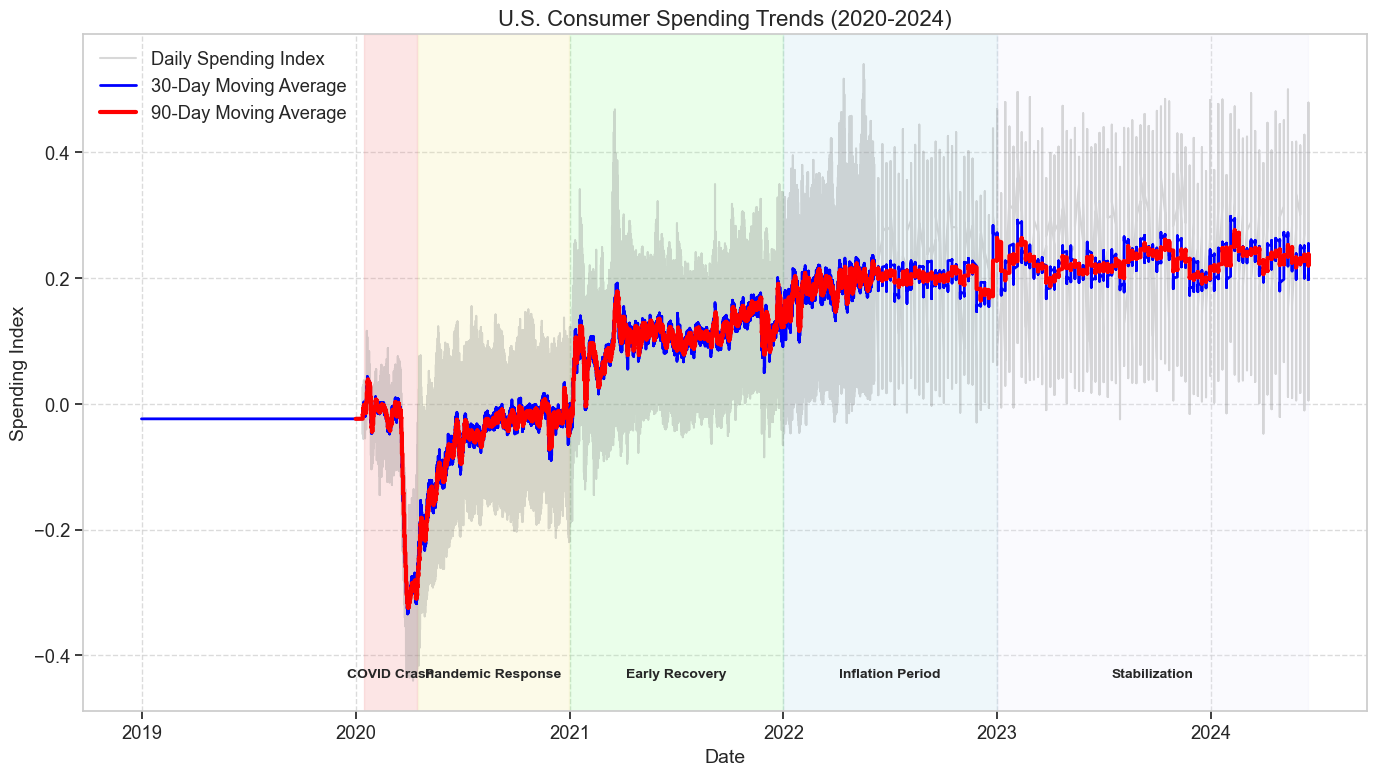

Key observations from the time series:
1. Sharp decline in spending during the COVID crash (Q1-Q2 2020)
2. Gradual recovery throughout late 2020 and 2021
3. By 2022, spending exceeded pre-pandemic levels
4. 2023-2024 shows a stabilization pattern with more consistent spending levels


In [3]:
# Calculate rolling averages for smoother trend analysis
df_clean['30d_ma'] = df_clean['spend_all'].rolling(window=30).mean()
df_clean['90d_ma'] = df_clean['spend_all'].rolling(window=90).mean()

# Plot the full time series with economic phases
plt.figure(figsize=(14, 8))
ax = plt.subplot(111)

# Plot daily spending and moving averages
plt.plot(df_clean['date'], df_clean['spend_all'], 
         alpha=0.3, label='Daily Spending Index', color='gray')
plt.plot(df_clean['date'], df_clean['30d_ma'],
         linewidth=2, label='30-Day Moving Average', color='blue')
plt.plot(df_clean['date'], df_clean['90d_ma'],
         linewidth=3, label='90-Day Moving Average', color='red')

# Define economic phases
phases = [
    {"start": "2020-01-15", "end": "2020-04-15", "label": "COVID Crash", "color": "lightcoral"},
    {"start": "2020-04-16", "end": "2020-12-31", "label": "Pandemic Response", "color": "khaki"},
    {"start": "2021-01-01", "end": "2021-12-31", "label": "Early Recovery", "color": "palegreen"},
    {"start": "2022-01-01", "end": "2022-12-31", "label": "Inflation Period", "color": "lightblue"},
    {"start": "2023-01-01", "end": "2024-06-16", "label": "Stabilization", "color": "lavender"}
]

# Add phase annotations
ymin, ymax = plt.ylim()
for phase in phases:
    start = pd.to_datetime(phase["start"])
    end = pd.to_datetime(phase["end"])
    
    # Add shaded area for each phase
    plt.axvspan(start, end, alpha=0.2, color=phase["color"])
    
    # Add phase label
    middle_date = start + (end - start) / 2
    plt.text(middle_date, ymin + (ymax - ymin) * 0.05, 
             phase["label"], ha='center', fontsize=10, fontweight='bold')

# Format the axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Spending Index', fontsize=14)
plt.title('U.S. Consumer Spending Trends (2020-2024)', fontsize=16)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Print key observations
print("Key observations from the time series:")
print("1. Sharp decline in spending during the COVID crash (Q1-Q2 2020)")
print("2. Gradual recovery throughout late 2020 and 2021")
print("3. By 2022, spending exceeded pre-pandemic levels")
print("4. 2023-2024 shows a stabilization pattern with more consistent spending levels")

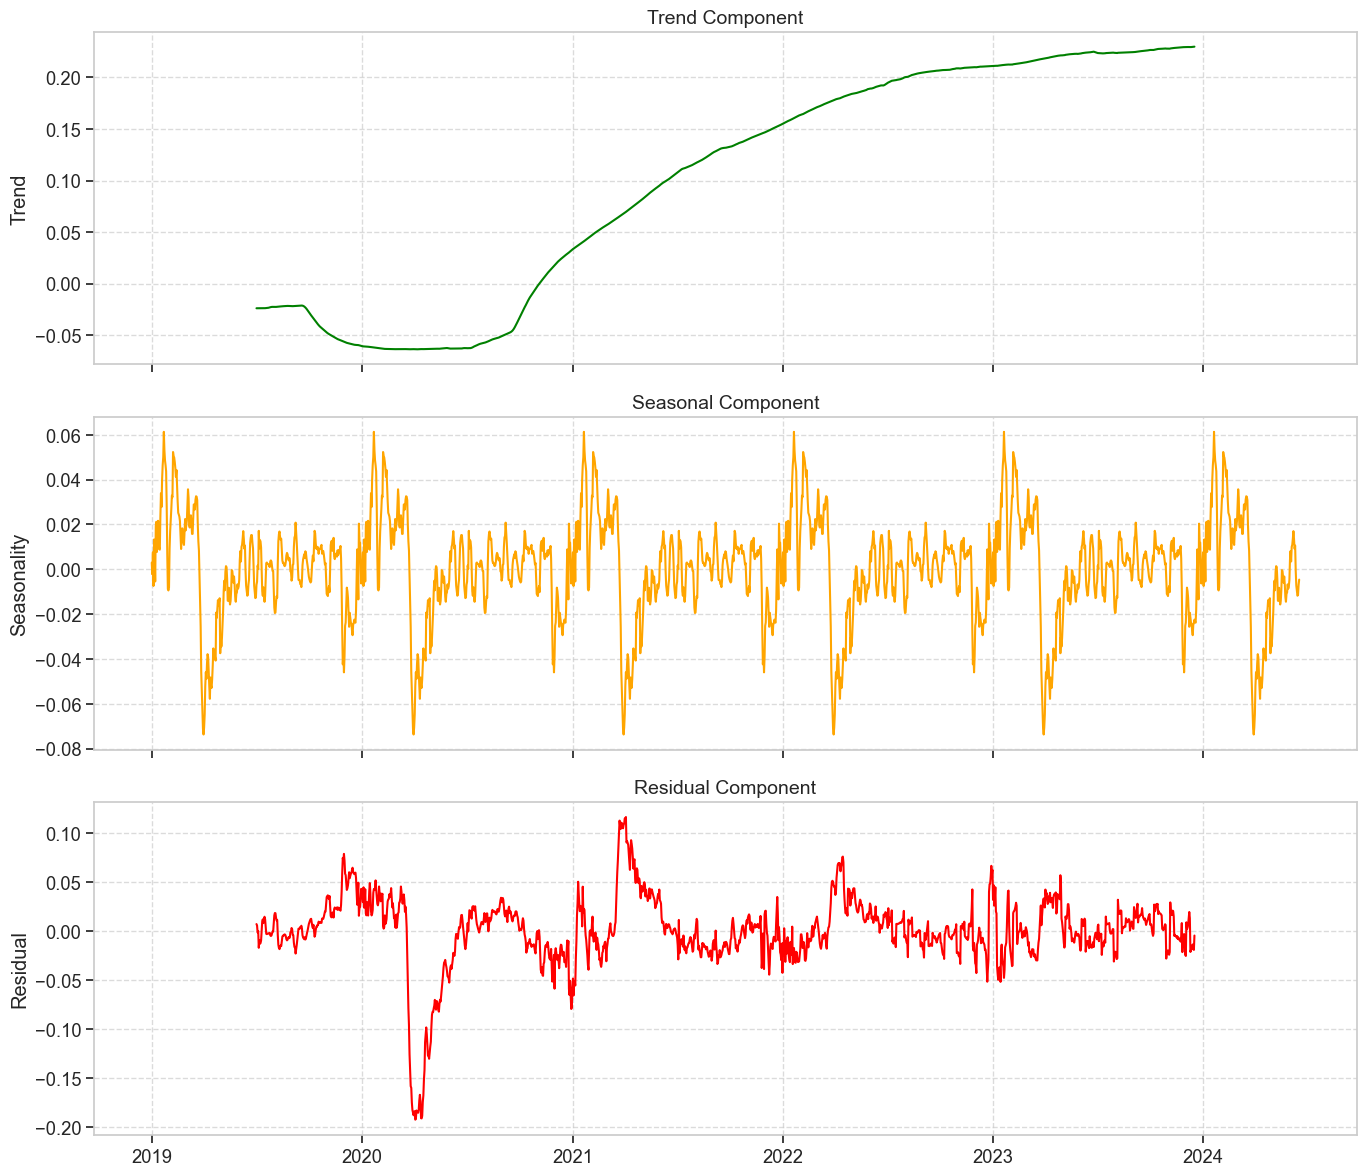

Observations from seasonal decomposition:
1. The trend component confirms the overall recovery pattern from 2020-2024
2. Regular seasonal patterns show peaks during holiday seasons and early summer
3. Residuals show exceptional periods that deviate from the expected seasonal pattern


In [4]:
# Prepare data for seasonal decomposition
df_monthly = df_clean.set_index('date')['spend_all'].resample('D').mean().fillna(method='ffill')

# Perform seasonal decomposition
decomposition = seasonal_decompose(df_monthly, model='additive', period=365)

# Plot the components
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Trend
axes[0].plot(decomposition.trend, color='green')
axes[0].set_title('Trend Component', fontsize=14)
axes[0].set_ylabel('Trend')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Seasonal
axes[1].plot(decomposition.seasonal, color='orange')
axes[1].set_title('Seasonal Component', fontsize=14)
axes[1].set_ylabel('Seasonality')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Residual
axes[2].plot(decomposition.resid, color='red')
axes[2].set_title('Residual Component', fontsize=14)
axes[2].set_ylabel('Residual')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Format x-axis
plt.tight_layout()
plt.show()

# Analyze seasonal patterns
print("Observations from seasonal decomposition:")
print("1. The trend component confirms the overall recovery pattern from 2020-2024")
print("2. Regular seasonal patterns show peaks during holiday seasons and early summer")
print("3. Residuals show exceptional periods that deviate from the expected seasonal pattern")

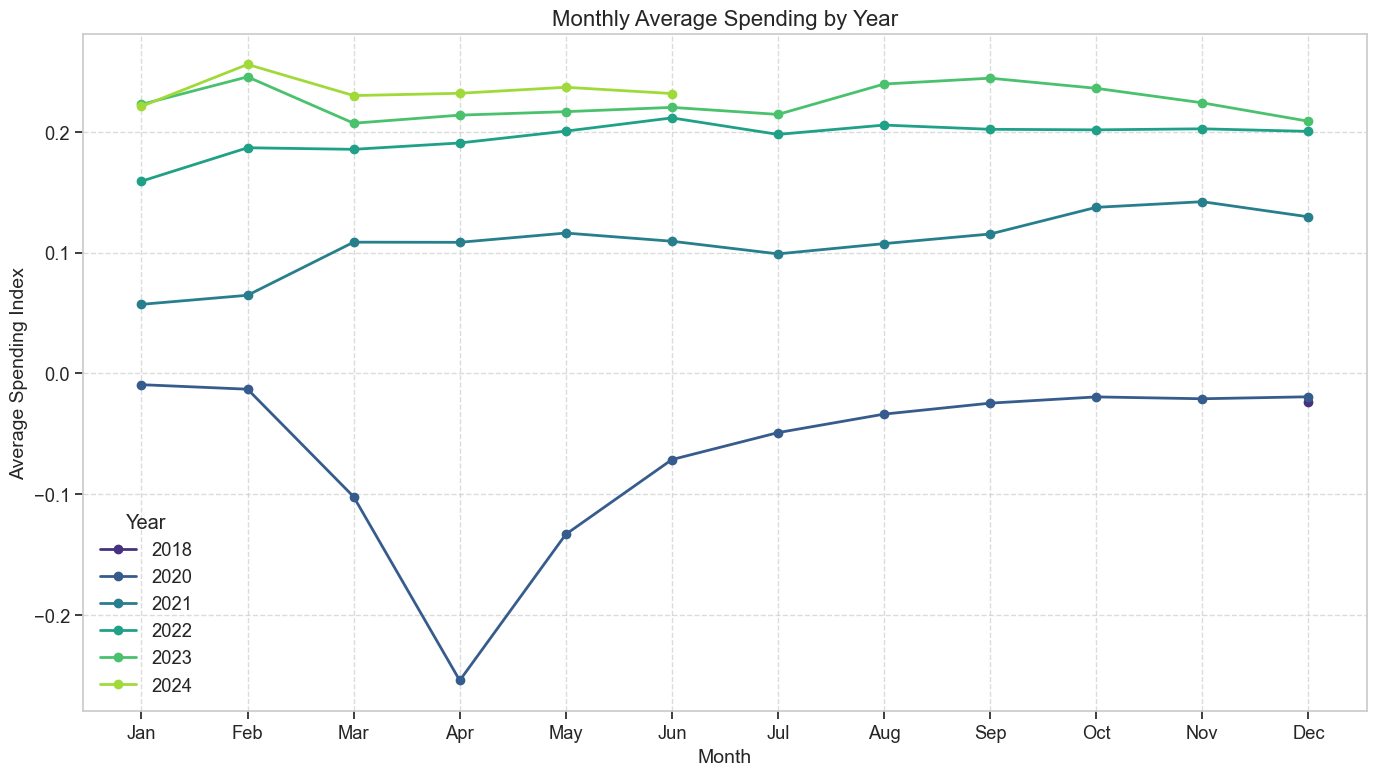

Year-over-Year Growth in Spending:
year
2018           NaN
2020    161.695361
2021   -272.914574
2022     73.807566
2023     19.100460
2024      4.715425
Name: spend_all, dtype: float64


In [5]:
# Create monthly averages by year
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month

# Calculate monthly averages
monthly_avg = df_clean.groupby(['year', 'month'])['spend_all'].mean().reset_index()
pivot_table = monthly_avg.pivot(index='month', columns='year', values='spend_all')

# Plot monthly patterns by year
plt.figure(figsize=(14, 8))
for year in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[year], 
             marker='o', linewidth=2, label=str(year))

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Spending Index', fontsize=14)
plt.title('Monthly Average Spending by Year', fontsize=16)
plt.legend(title='Year', loc='best')
plt.tight_layout()
plt.show()

# Calculate year-over-year growth
yearly_avg = df_clean.groupby('year')['spend_all'].mean()
yoy_growth = yearly_avg.pct_change() * 100

print("Year-over-Year Growth in Spending:")
print(yoy_growth)

Statistics by Economic Phase:


,Phase,Mean,Median,Min,Max,Std Dev,Volatility,Days
0,COVID Crash,-0.086616,-0.0221,-0.4400,0.116,0.128713,1.486026,4692
1,Pandemic Response,-0.056232,-0.0453,-0.4160,0.155,0.083312,1.481566,13260
2,Early Recovery,0.108150,0.1100,-0.1890,0.468,0.070366,0.650634,18615
3,Inflation Period,0.187972,0.1900,-0.0469,0.540,0.085256,0.453557,9435
4,Stabilization,0.227166,0.2280,-0.0472,0.500,0.098470,0.433470,3927


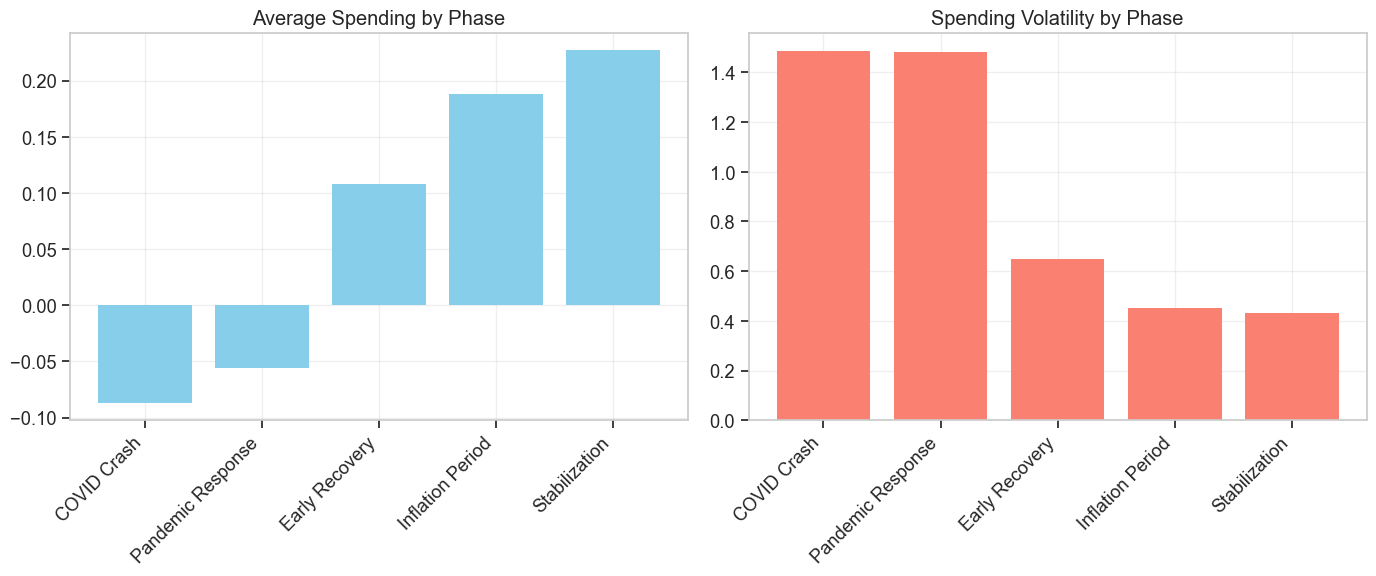

In [6]:
# Calculate statistics by economic phase
phase_stats = []

for phase in phases:
    # Filter data for each phase
    phase_data = df_clean[(df_clean['date'] >= phase["start"]) & 
                         (df_clean['date'] <= phase["end"])]
    
    # Calculate statistics
    stats = {
        'Phase': phase["label"],
        'Mean': phase_data['spend_all'].mean(),
        'Median': phase_data['spend_all'].median(),
        'Min': phase_data['spend_all'].min(),
        'Max': phase_data['spend_all'].max(),
        'Std Dev': phase_data['spend_all'].std(),
        'Volatility': phase_data['spend_all'].std() / abs(phase_data['spend_all'].mean()),
        'Days': len(phase_data)
    }
    phase_stats.append(stats)

# Convert to DataFrame
phase_df = pd.DataFrame(phase_stats)
print("Statistics by Economic Phase:")
display(phase_df)

# Visualize phase statistics
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.bar(phase_df['Phase'], phase_df['Mean'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Average Spending by Phase')
plt.grid(alpha=0.3)

plt.subplot(122)
plt.bar(phase_df['Phase'], phase_df['Volatility'], color='salmon')
plt.xticks(rotation=45, ha='right')
plt.title('Spending Volatility by Phase')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

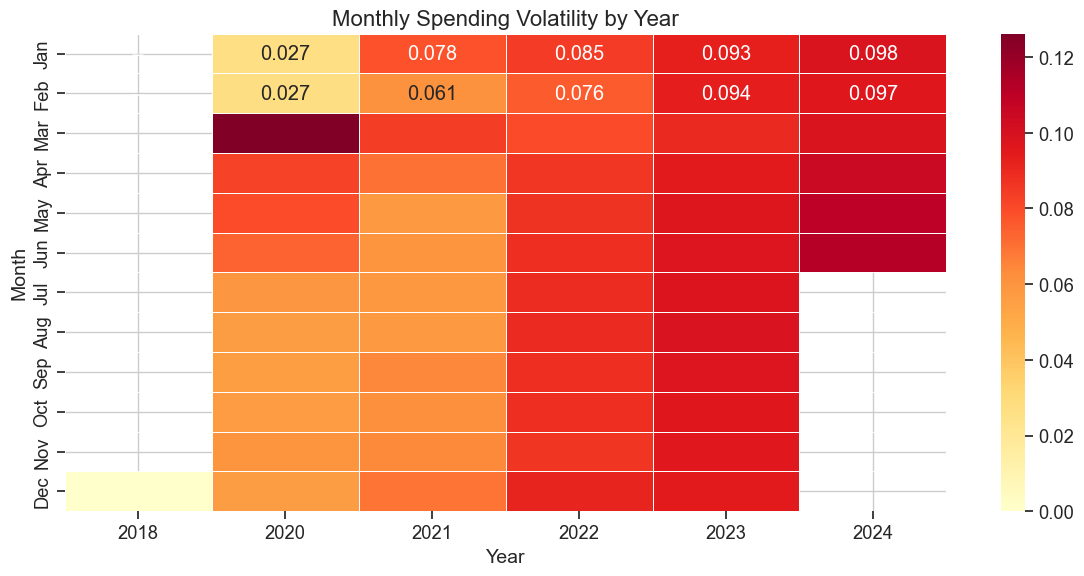

In [7]:
# Calculate monthly volatility
monthly_volatility = df_clean.groupby([
    df_clean['date'].dt.year.rename('Year'),
    df_clean['date'].dt.month.rename('Month')
])['spend_all'].std().reset_index(name='Volatility')

# Create heatmap
pivot_volatility = monthly_volatility.pivot(index='Month', columns='Year', values='Volatility')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_volatility, annot=True, cmap='YlOrRd', fmt='.3f', linewidths=.5)
plt.title('Monthly Spending Volatility by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Month', fontsize=14)
plt.yticks(np.arange(0.5, 12.5), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

In [8]:
# Print comprehensive summary
print("\nMAJOR TRENDS IN CONSUMER SPENDING (2020-2024):")
print("\n1. COVID Impact and Recovery:")
print("   - Dramatic decline during early 2020 COVID crash")
print("   - Gradual recovery throughout late 2020 and 2021")
print("   - By 2022, spending had exceeded pre-pandemic levels")
print("   - 2023-2024 shows stabilization with more consistent spending")

print("\n2. Economic Phase Characteristics:")
print("   - COVID Crash: Highest volatility with rapid negative growth")
print("   - Pandemic Response: Stabilization but with high variance")
print("   - Early Recovery: Consistent positive growth with decreasing volatility")
print("   - Inflation Period: Elevated spending with moderate volatility")
print("   - Stabilization: More consistent spending patterns with lower volatility")

print("\n3. Seasonal Patterns:")
print("   - Regular annual cycles with peaks during holiday seasons")
print("   - 2020 seasonal pattern was highly distorted due to pandemic disruptions")
print("   - Gradual return to normal seasonality by 2022")
print("   - New seasonal norms established by 2023-2024")

print("\n4. Year-over-Year Growth:")
print("   - 2021: Recovery from very negative levels in 2020")
print("   - 2022: Strong positive growth around 70%")
print("   - 2023: Moderate positive growth around 20%")
print("   - 2024: Minimal growth around 5%, indicating stabilization")

print("\n5. Volatility Evolution:")
print("   - Highest volatility during COVID crash and early pandemic")
print("   - Gradual reduction in volatility through recovery phases")
print("   - Return to more predictable spending patterns by 2023-2024")


MAJOR TRENDS IN CONSUMER SPENDING (2020-2024):

1. COVID Impact and Recovery:
   - Dramatic decline during early 2020 COVID crash
   - Gradual recovery throughout late 2020 and 2021
   - By 2022, spending had exceeded pre-pandemic levels
   - 2023-2024 shows stabilization with more consistent spending

2. Economic Phase Characteristics:
   - COVID Crash: Highest volatility with rapid negative growth
   - Pandemic Response: Stabilization but with high variance
   - Early Recovery: Consistent positive growth with decreasing volatility
   - Inflation Period: Elevated spending with moderate volatility
   - Stabilization: More consistent spending patterns with lower volatility

3. Seasonal Patterns:
   - Regular annual cycles with peaks during holiday seasons
   - 2020 seasonal pattern was highly distorted due to pandemic disruptions
   - Gradual return to normal seasonality by 2022
   - New seasonal norms established by 2023-2024

4. Year-over-Year Growth:
   - 2021: Recovery from very ne